In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download 'jangedoo/utkface-new'

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 331M/331M [00:16<00:00, 24.0MB/s]
100% 331M/331M [00:16<00:00, 21.6MB/s]


In [ ]:
!unzip /content/utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
BASE_DIR = "/content/utkface_aligned_cropped/UTKFace"

In [ ]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR,filename)
    temp = filename.split("_")
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame()
df["image"], df["age"], df["gender"] = image_paths, age_labels, gender_labels
df.head(5)

image  age  gender
0  /content/utkface_aligned_cropped/UTKFace/28_1_...   28       1
1  /content/utkface_aligned_cropped/UTKFace/26_1_...   26       1
2  /content/utkface_aligned_cropped/UTKFace/40_0_...   40       0
3  /content/utkface_aligned_cropped/UTKFace/39_1_...   39       1
4  /content/utkface_aligned_cropped/UTKFace/5_0_3...    5       0

In [ ]:
gender_dict = {0:"Male",1:"Female"}

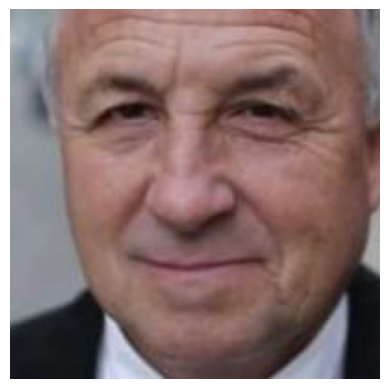

In [ ]:
from PIL import Image
img = Image.open(df["image"][5])
plt.axis("off")
plt.imshow(img);

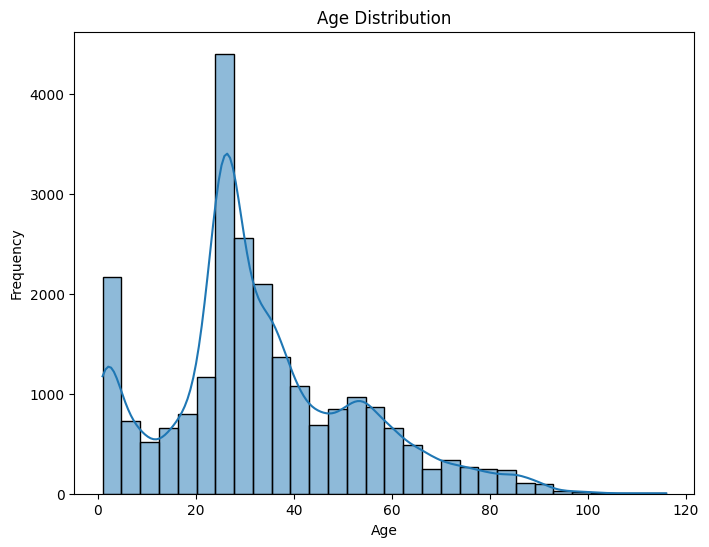

In [ ]:
#Age Distribution Plot
plt.figure(figsize=(8, 6))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

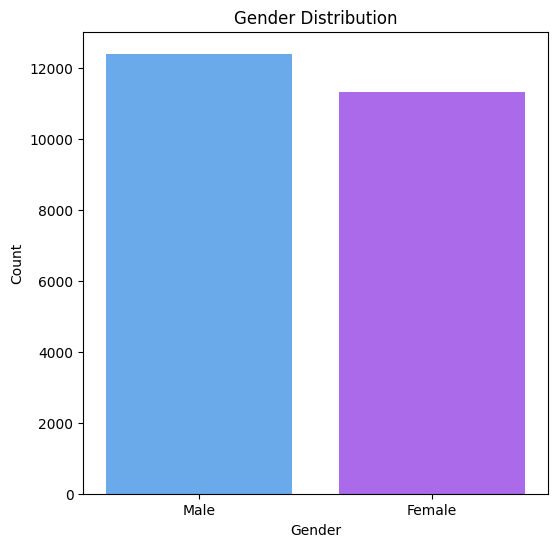

In [ ]:
#Gender Distribution Plot
plt.figure(figsize=(6, 6))
sns.countplot(x="gender", data=df, palette="cool")
plt.title("Gender Distribution")
plt.xticks([0, 1], ["Male", "Female"])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [ ]:
# sns.distplot(df["age"])

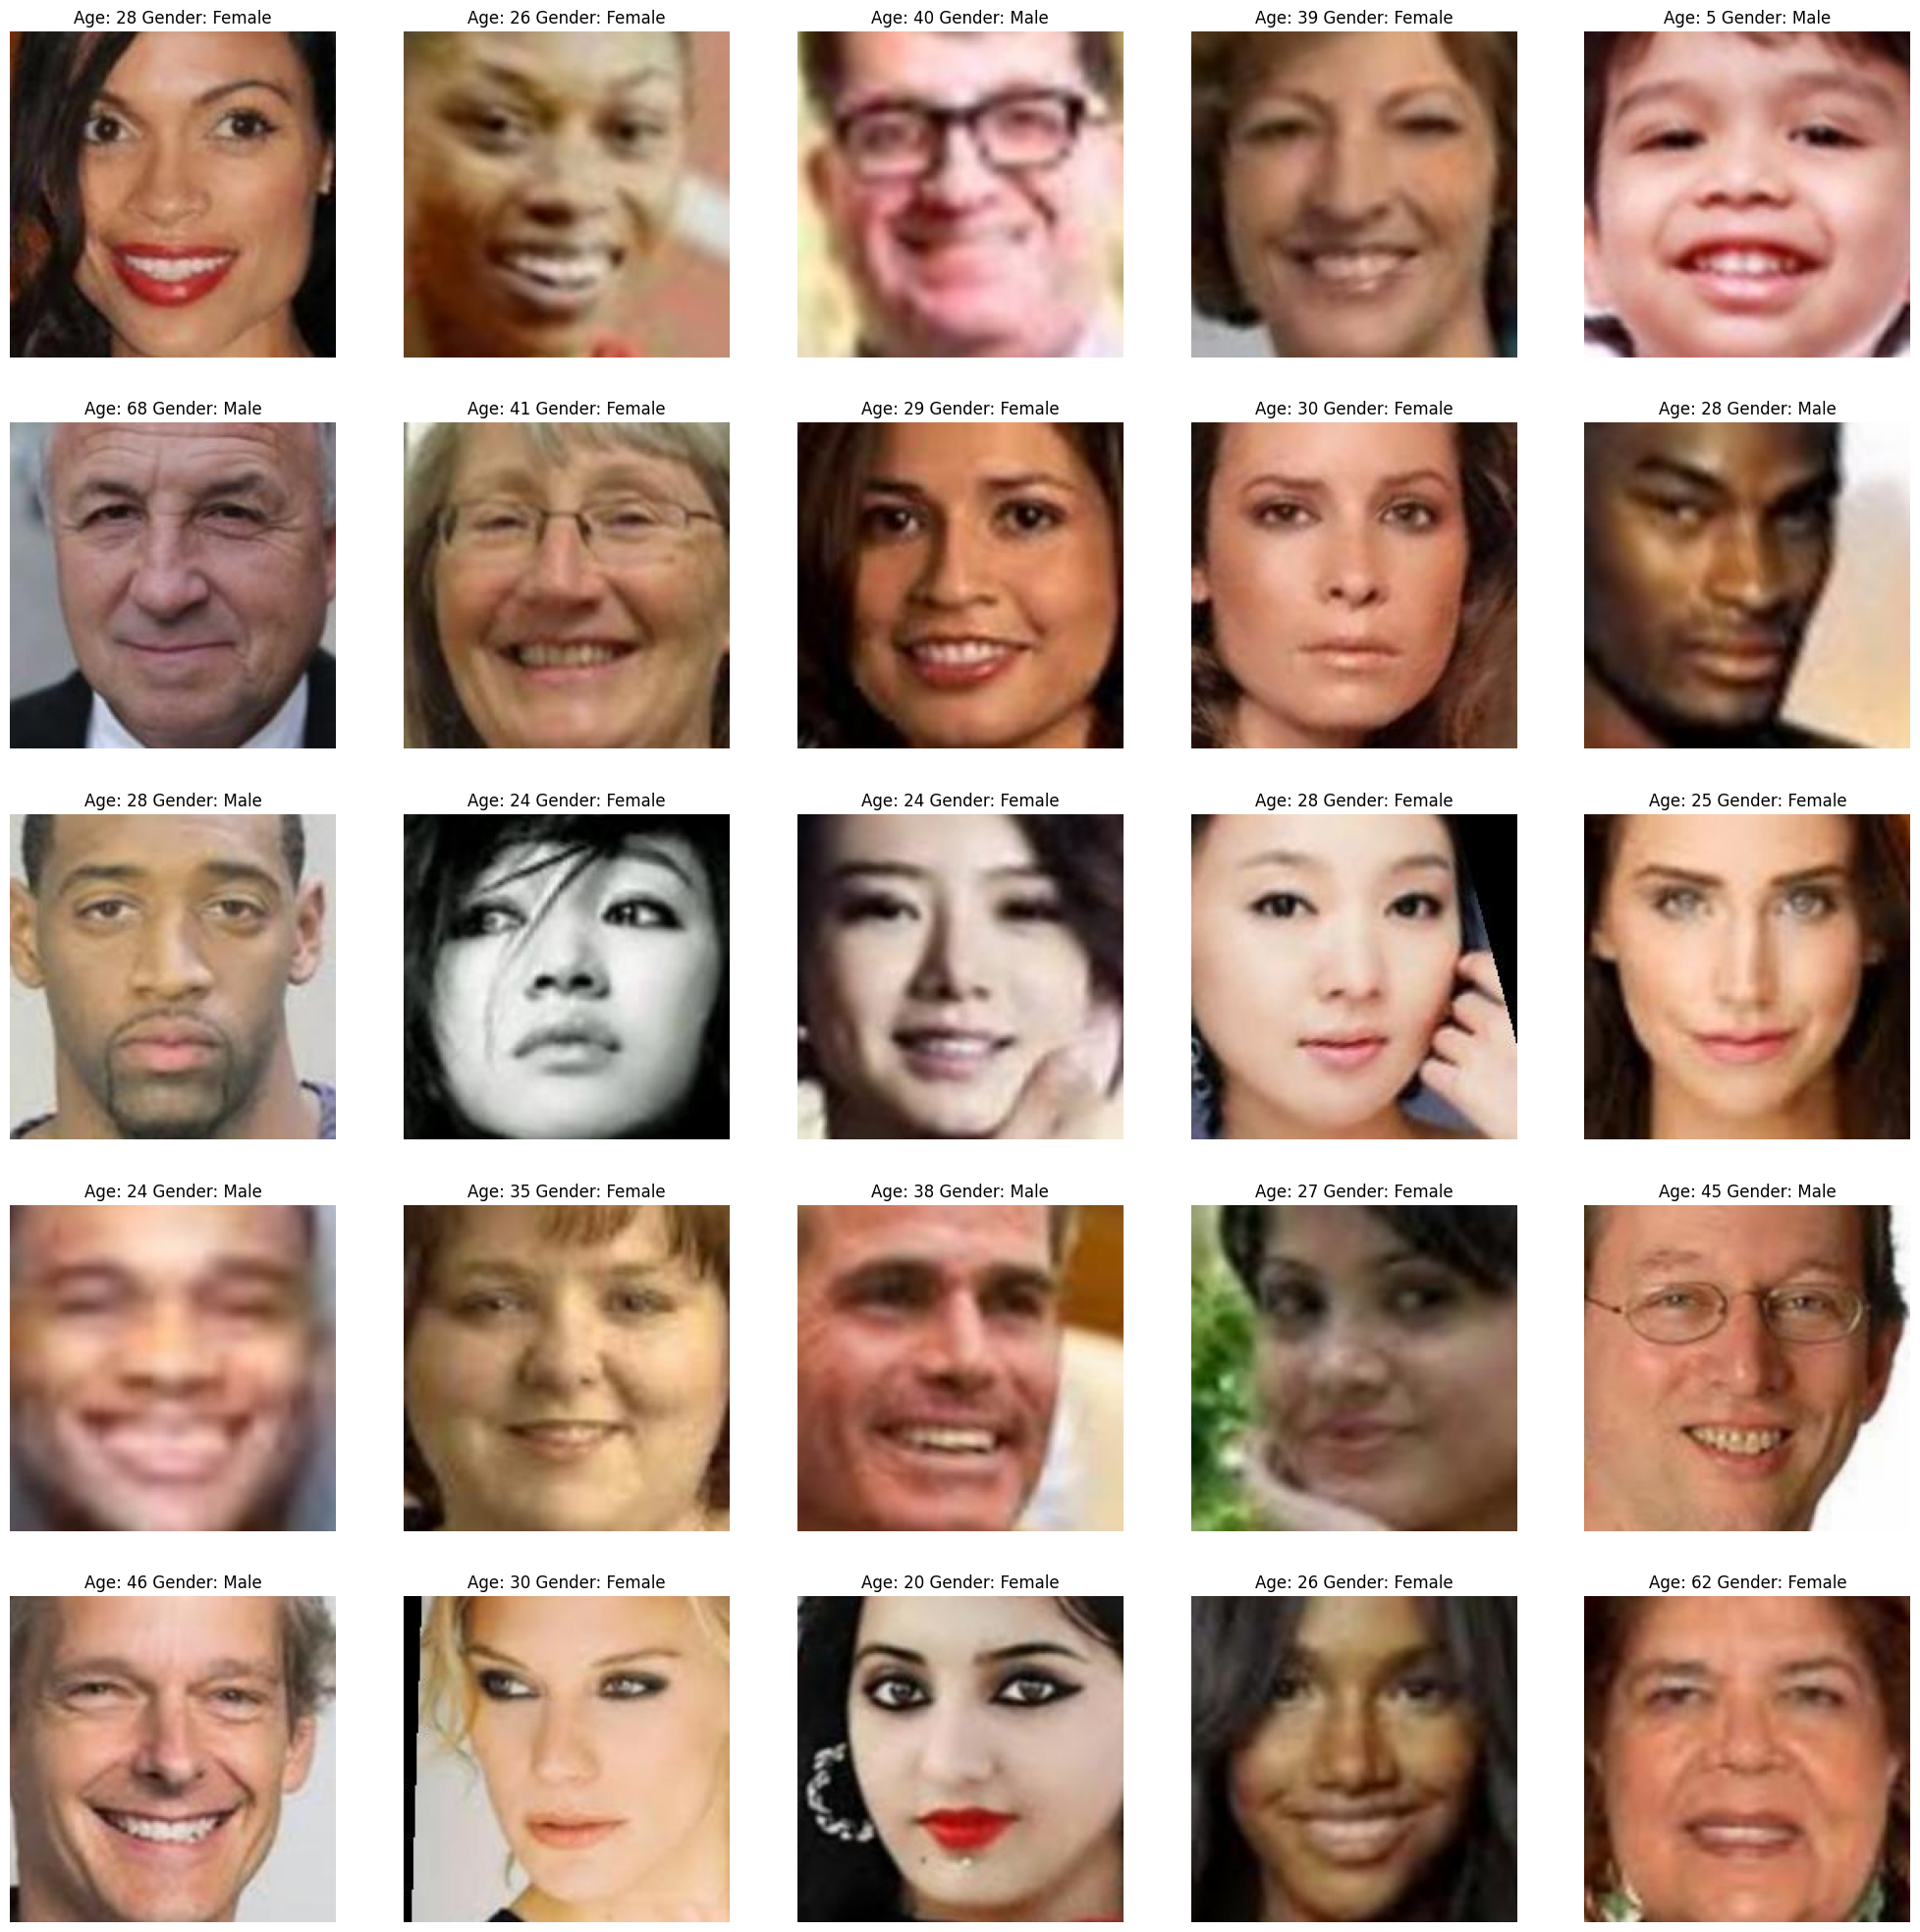

In [ ]:
plt.figure(figsize=(25,25))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis("off")

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
from tqdm import tqdm
import numpy as np

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.LANCZOS)  # Use LANCZOS instead of ANTIALIAS
        img = np.array(img)
        features.append(img)
    return np.array(features)

In [ ]:
X = extract_features(df["image"])

100%|██████████| 23708/23708 [00:33<00:00, 702.51it/s]


In [ ]:
X.shape

(23708, 128, 128)

In [ ]:
X = X/255.0

In [ ]:
y_gender = np.array(df["gender"])
y_age = np.array(df["age"])

In [ ]:
input_shape = (128,128,1)

inputs = Input(input_shape)
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten()(maxp_4)

dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name="gender_out")(dropout_1)
output_2 = Dense(1, activation='relu', name="age_out")(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 256)    │        147,712 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 256)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50176)          │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │     12,845,312 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │     12,845,312 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_out (Dense)        │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_out (Dense)           │ (None, 1)              │            257 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,857,666 (98.64 MB)

 Trainable params: 25,857,666 (98.64 MB)

 Non-trainable params: 0 (0.00 B)

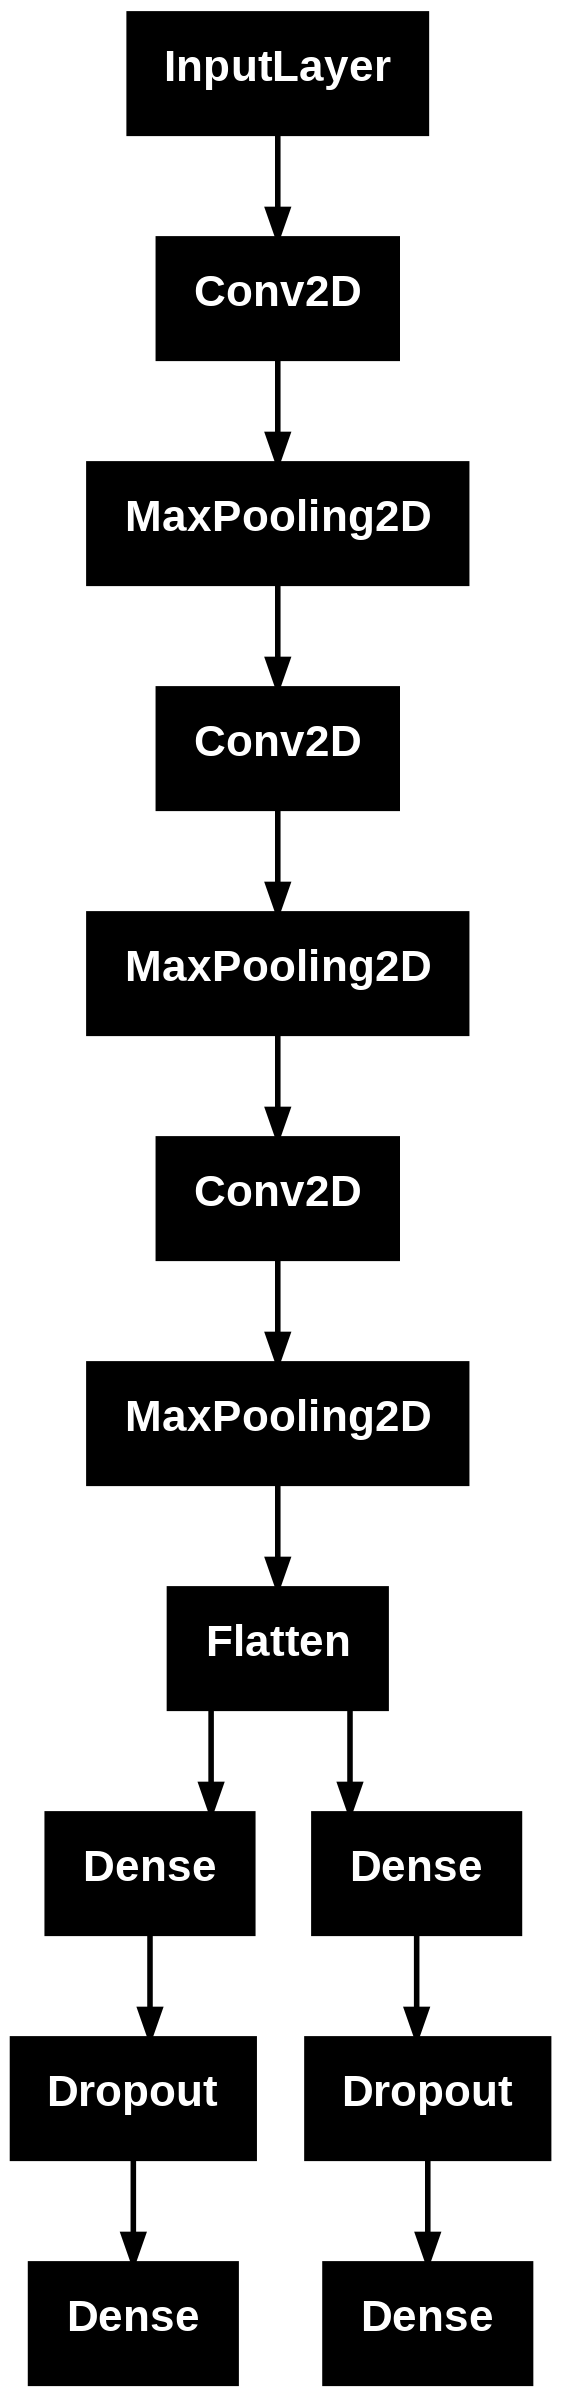

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# model.compile(optimizer='adam',
#               loss=['binary_crossentropy', 'mse'],
#               metrics=[['accuracy']])

In [ ]:
model.compile(optimizer='adam',
              loss=['binary_crossentropy', 'mse'],
              metrics=['accuracy', 'mae'])

In [ ]:
# model.compile(optimizer='adam',
#               loss=['binary_crossentropy', 'mae'],  # losses for each output
#               metrics=['accuracy'])  # metrics for each output

In [ ]:
# model.compile(loss=["binary_crossentropy", "mae"], optimizer="adam", metrics=["accuracy"])

In [ ]:
# from tensorflow.keras.optimizers import Adam

# # Adjust the learning rate for better convergence
# model.compile(optimizer=Adam(learning_rate=0.0001),
#               loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
#               metrics=['accuracy', 'mae'])


In [ ]:
# model.compile(loss=["binary_crossentropy", "mae"], optimizer="adam", metrics=["accuracy","mse"])

In [ ]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
  1/593 ━━━━━━━━━━━━━━━━━━━━ 1:29:09 9s/step - age_out_mae: 28.0884 - gender_out_accuracy: 0.5625 - loss: 1028.8812

In [ ]:
# #Training and Validation Loss Curves
# # Plot gender loss
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['gender_out_loss'], label='Train Gender Loss')
# plt.plot(history.history['val_gender_out_loss'], label='Validation Gender Loss')
# plt.title("Gender Loss During Training")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# # Plot age loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['age_out_loss'], label='Train Age Loss')
# plt.plot(history.history['val_age_out_loss'], label='Validation Age Loss')
# plt.title("Age Loss During Training")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# plt.tight_layout()
# plt.show()


Training and Validation Accuracy for Gender Prediction

In [ ]:
#Training and Validation Accuracy for Gender Prediction
plt.figure(figsize=(8, 6))
plt.plot(history.history['gender_out_accuracy'], label='Train Gender Accuracy')
plt.plot(history.history['val_gender_out_accuracy'], label='Validation Gender Accuracy')
plt.title("Gender Classification Accuracy During Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

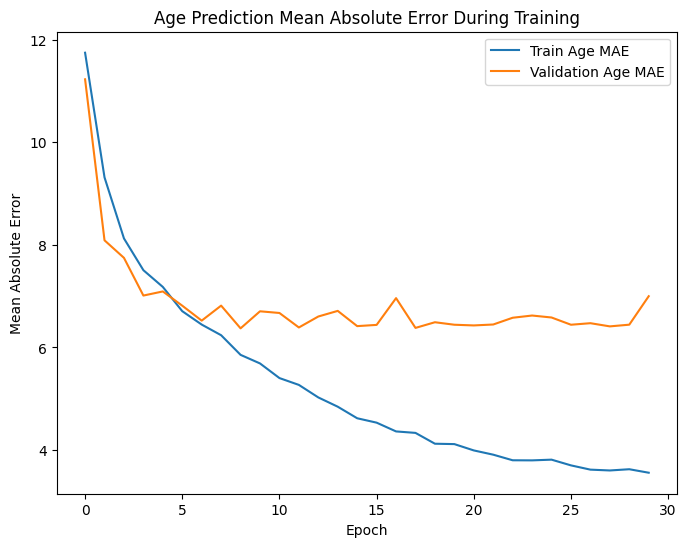

In [ ]:
#Mean Absolute Error (MAE) for Age Prediction
plt.figure(figsize=(8, 6))
plt.plot(history.history['age_out_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_out_mae'], label='Validation Age MAE')
plt.title("Age Prediction Mean Absolute Error During Training")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()


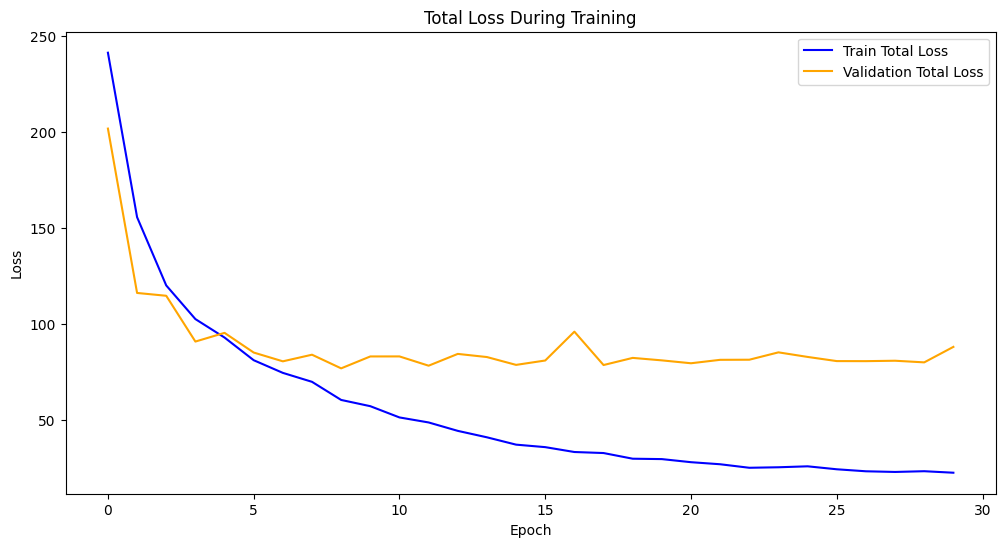

In [ ]:
# Plotting Losses
plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'], label='Train Total Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Total Loss', color='orange')
plt.title("Total Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


<Figure size 640x480 with 0 Axes>

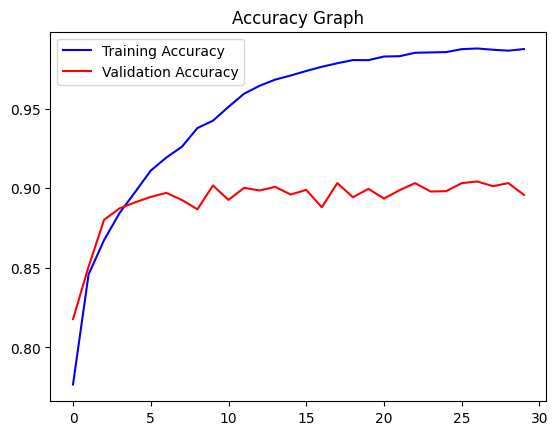

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history["gender_out_accuracy"]
val_acc = history.history["val_gender_out_accuracy"]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
plt.title("Accuracy Graph")
plt.legend()
plt.figure()

In [ ]:
# loss = history.history["gender_out_loss"]
# val_loss = history.history["val_gender_out_loss"]

# plt.plot(epochs, loss, 'b', label="Training Loss")
# plt.plot(epochs, val_loss, 'r', label="Validation Loss")
# plt.title("Loss Graph")
# plt.legend()
# plt.show()

In [ ]:
# loss = history.history["age_out_loss"]
# val_loss = history.history["val_age_out_loss"]

# epochs = range(len(loss))

# plt.plot(epochs, loss, 'b', label="Training Loss")
# plt.plot(epochs, val_loss, 'r', label="Validation Loss")
# plt.title("Loss Graph")
# plt.legend()
# plt.show()

Original Gender: Male, Original Age: 38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Male, Predicted Age: 21


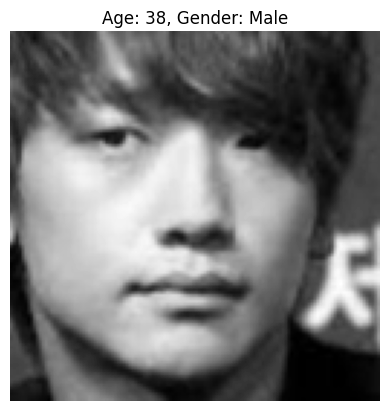

In [ ]:
import random
# Generate a random index
random_index = random.randint(0, len(X) - 1)

# Display original gender and age
print(f"Original Gender: {gender_dict[y_gender[random_index]]}, Original Age: {y_age[random_index]}")

# Make predictions
pred = model.predict(X[random_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

# Display predictions
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")

# Plot the randomly selected image
plt.imshow(X[random_index].reshape(128, 128), cmap='gray')
plt.axis("off")
plt.title(f"Age: {y_age[random_index]}, Gender: {gender_dict[y_gender[random_index]]}")
plt.show()
